In [1]:
from io import BytesIO

import pandas as pd
import numpy as np
import numpy
import panel as pn
pn.extension('tabulator')
import matplotlib.pyplot as plt
import hvplot.pandas
import matplotlib.gridspec as gridspec
import matplotlib
import holoviews as hv
import param


In [2]:
cm = 1/2.54  # centimeters in inches

## Color

In [3]:
from itertools import cycle
main_colours = ['yellow', 'navajowhite', 'orange','orangered','red','darkslateblue','mediumpurple','green','yellowgreen','cyan','lightblue']
l_main_colours = cycle(main_colours)
r_main_colours = cycle(main_colours[::-1])
l_sub_colours = cycle(main_colours)
r_sub_colours = cycle(main_colours[::-1])

In [4]:
def get_number_of_rows(dataframe):
    df = pd.read_csv(dataframe)
    return df.shape[0]

In [5]:
def iqr(array):
    q3, q1 = np.percentile(array,[75,25])
    IQR = q3 - q1
    upper_bound = q3 + 1.5*IQR
    lower_bound = q1 - 1.5*IQR
    return lower_bound, upper_bound

In [6]:
@pn.cache
def fetch_data(dataframe_list):
    size = []
    data_frames = []
    for data in dataframe_list:
        df = pd.read_csv(data)
        df.drop('time', axis = 1, inplace = True)
        df.insert(0,'time',df.index.values)
        df = df.fillna(0)
        size.append(df.shape[0])
        data_frames.append(df)
        minsize = min(size)
    return data_frames, minsize


def cut_data(df, maxsize):
    for column in df.keys():
        upper_bound = maxsize
        df = df[df[column] < upper_bound ]
    return df

## Define widgets

In [7]:
file_input = pn.widgets.FileInput( sizing_mode='stretch_width',
                                  multiple=True)

In [8]:
columns = ['shoulder','elbow','knee','hip']
select_column = pn.widgets.Select(options=columns)
direction = ['l','r']
select_direction =  pn.widgets.Select(options=direction)

In [9]:
@pn.cache
def plot(data = None, limb = 'shoulder',direction = 'l'):
    fig =  plt.figure(num=1, clear=True, figsize=(25*cm, 15*cm))
    spec = fig.add_gridspec(ncols=2, nrows=2)
    ax0 = fig.add_subplot(spec[0, :])
    ax1 = fig.add_subplot(spec[1, 0])
    ax2 = fig.add_subplot(spec[1, 1])
    ymax = 1.0
    if file_input.filename != None:    
        dataframes, min_size = fetch_data(file_input.filename)
        for data in dataframes:
            data = cut_data(data, min_size)
            ax0.plot(data[limb + "L" + "angle"],color = next(l_main_colours))
            ax0.plot(data[limb + "R" + "angle"], color = next(r_main_colours))
            ax0.set_title(limb + "L" + "angle & "+limb +"R" + "angle")
            if ax0.get_ylim()[1] > ymax:
                ymax = ax0.get_ylim()[1]
            ax1.set_title(limb + "L" + "angle")
            ax1.plot(data[limb + "L" + "angle"],color = next(l_sub_colours))
            ax2.set_title(limb + "R" + "angle")
            ax2.plot(data[limb + "R" + "angle"], color = next(r_sub_colours))
        ax0.set_ylim(0,ymax)
        ax1.set_ylim(0,ymax)
        ax2.set_ylim(0,ymax)
    return fig


## Define context binding widgets

In [10]:
def get_files(file_):
    if file_input.filename != None:
        file_input.save(file_input.filename)

pn.bind(get_files, file_input, watch= True)

<function panel.depends._param_bind.<locals>.wrapped(*wargs, **wkwargs)>

In [11]:
def update_select(files_ = None):
    if file_input.filename == None:
            selector = pn.widgets.MultiSelect(
            name=' ', sizing_mode='stretch_width',
            options=['Add your files here'])
            return selector
    else:
        selector = pn.widgets.MultiSelect(
        name=' ', sizing_mode='stretch_width',
        options=file_input.filename)
        file_input.save(file_input.filename)
        return selector


selected = pn.bind(update_select,file_input, watch= True)

## Debug button

In [12]:
button = pn.widgets.Button(name='Debug', button_type='primary')
text = pn.widgets.TextInput(value='Ready')

def b(event):
    breakpoint()
def debug(event):
    breakpoint()
button.on_click(b)


Watcher(inst=Button(button_type='primary', name='Debug'), cls=<class 'panel.widgets.button.Button'>, fn=<function b at 0x7f67829b6670>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

In [13]:
main_widget = pn.bind(plot, file_input,select_column,select_direction, watch = True)

## Create the Template

Launching server at http://localhost:41807


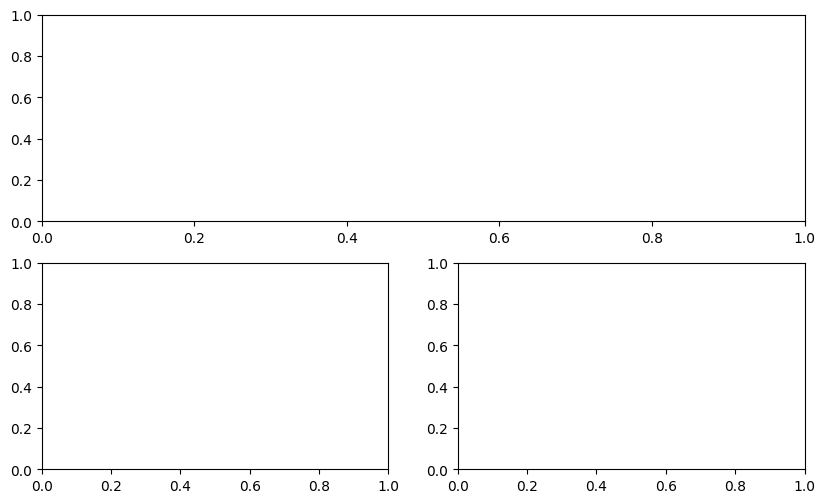

In [14]:
#Layout using Template
template = pn.template.BootstrapTemplate(
    title='Data analysis for motor disabilities rehabilitation of the upper limbs using augmented reality', 
    sidebar=[pn.pane.Markdown(""), 
             file_input,
             button,
             select_column,
             select_direction,
             pn.pane.Markdown("## Selected Files"), 
             selected
            ],
    main=[ pn.Tabs(("Main", main_widget))],
    header_background='purple',
)
template.show()
template.servable();